# IBM Model 1

Type of dataset to work with

```
[
  {"fr": "la maison",        "en": "the house"},
  {"fr": "la fleur",         "en": "the flower"},
  {"fr": "la maison bleu",   "en": "the blue house"},
  {"fr": "la fleur bleu",    "en": "the blue flower"},
  {"fr": "pomme bleu",       "en": "blue apple"}
]
```


**Pseudo-code of EM for IBM Model 1:**

```
 initialize t(e|f) uniformly
 do until convergence
   set count(e|f) to 0 for all e,f
   set total(f) to 0 for all f
   for all sentence pairs (e_s,f_s)
     set total_s(e) = 0 for all e
     for all words e in e_s
       for all words f in f_s
         total_s(e) += t(e|f)
     for all words e in e_s
       for all words f in f_s
         count(e|f) += t(e|f) / total_s(e)
         total(f)   += t(e|f) / total_s(e)
   for all f
     for all e
       t(e|f) = count(e|f) / total(f)
```

# Functions

## Import Files

In [ ]:
import pandas as pd                           # data handling
import numpy as np
from tqdm import tqdm                         # show progess bar
import time                                   # to time the preocess
import matplotlib.pyplot as plt               # plotting graphs
import matplotlib
import re                                     # regular expression
from collections import Counter, defaultdict  # used to convert dict to dataframe
import joblib
import math
from decimal import Decimal
from tqdm import tqdm_notebook
import warnings
import seaborn as sns
%matplotlib inline

## **Generate Vocabulary**

Here we create a list of all unique French and English words from the parallel corpus.

In [ ]:
def generate_vocab(parallel_corpus): # fr_vocab, en_vocab
  '''
    Input: parallel_corpus
    Type: Json object
    e.x. corpus = [{"fr": "maison", "en": "house"}, ..., {"fr": "la", "en": "the"}]

  '''

  fr = []
  en = []
  for sent in parallel_corpus:
    fr.extend(sent['fr'].split())
    en.extend(sent['en'].split())

  # List of unique words
  fr_vocab = list(set(fr))
  en_vocab = list(set(en))

  return fr_vocab, en_vocab

## **Iteration**

Here you go through all the sentence pairs in the parallel corpus once and update out prior alignment probabilities.

In [ ]:
# Iteration 1
def iteration(corpus, fr_vocab, en_vocab, t_e_f):

  '''
    Inputs: corpus --> parallel corpus Json object
            fr_vocab --> A list object
            en_vocab --> A list object
            t_e_f (initial translation probabilities) --> Nested dictionary

  '''

  count_e_f = {e: {f: 0 for f in fr_vocab} for e in en_vocab}
  total_f = {f: 0 for f in fr_vocab}
  total_e = {}

  for sent in corpus:
    # total_e = {e: 0 for e in en_vocab}

    for e in sent['en'].split():
      total_e[e] = 0
      for f in sent['fr'].split():
        total_e[e] += t_e_f[e][f]

    for e in sent['en'].split():
      for f in sent['fr'].split():
        count_e_f[e][f] += t_e_f[e][f] / total_e[e]
        total_f[f] += t_e_f[e][f] / total_e[e]

  for f in fr_vocab:
    for e in en_vocab:
      t_e_f[e][f] = count_e_f[e][f] / total_f[f]

  return t_e_f

## **Probability of a sentence pair**

• We need to compute $p(e|f)$

$p(e|f) = \displaystyle\sum_{a} p(e, a|f)$

$ ~~~~~~~~~~~~ = \displaystyle\sum_{a(1)=0}^{l_f}...\sum_{a(l_e)=0}^{l_f} p(e, a|f)$

$ ~~~~~~~~~~~~ = \displaystyle\sum_{a(1)=0}^{l_f}...\sum_{a(l_e)=0}^{l_f} \frac{ϵ}{(l_f + 1)^{l_e}} \prod_{j=1}^{l_e} t(e_j, f_{a(j)})$

$ ~~~~~~~~~~~~ = \displaystyle \frac{ϵ}{(l_f + 1)^{l_e}} \sum_{a(1)=0}^{l_f}...\sum_{a(l_e)=0}^{l_f}  \prod_{j=1}^{l_e} t(e_j, f_{a(j)})$

$ ~~~~~~~~~~~~ = \displaystyle \frac{ϵ}{(l_f + 1)^{l_e}} \prod_{j=1}^{l_e} \sum_{i=0}^{l_f} t(e_j, f_i)$

In [ ]:
# Probability for Calculation of Perplexity
def prob_e_f(f_s,e_s,t,eps=1):
  """
  ARGUMENTS:
    f_s = list of tokens for french sentence
    e_s = list of tokens for english sentence
    t = dictionary of alignments

  OUTPUT :
    returns p(e|f) - translation probability
  """

  l_f = len(f_s)
  l_e = len(e_s)

  prod = 1    # This is for the iterative product of summations of t(e|f)
              # (i.e. product_j[sum_i(t(e_j|f_i))] )
  for e in e_s:
    sum = 0
    for f in f_s:
      sum = sum + t[e][f]
    prod = prod * sum

  p_e_f = prod * (eps / pow(l_f + 1.0,l_e))

  return p_e_f

## Evaluation

**Perplexity**: This gives us a way to measure the quality of our alignments learned from EM Algorithm. The lower the perplexity, the better the model performance.

$ \log_2 PP = - \displaystyle\sum_{s} \log_{2} p(e_s|f_s)$

In [ ]:
# Metric -->
def perplexity(corpus, align):

  # Initialize
  pp = 0

  # Loop over all rows
  for row in corpus:
    f_s = row['fr'].lower().strip().split()
    e_s = row['en'].lower().strip().split()

    prob_ef = prob_e_f(f_s,e_s,align)
    d = Decimal(prob_ef)         # This probability is very small
    # pp += math.log(d, 2)
    try:
      temp = math.log(d, 2)                       # so converted to decimal to ease in finding log
    except ValueError:
      temp = math.inf

    pp += temp

  perp = -pp

  # try:
  #   perp = round(pow(2.0, -pp))
  # except OverflowError:
  #   perp = math.inf

  return perp

## Train Alignments
**Train**: Here you go through the `Iteration` step multiple times and also measure the perplexity of the new alignments learned at each step.

In [ ]:
# Model Training

def train(corpus, epochs=5, result=10):
  '''
    Input: Corpus (Cleaned corpus)
           Epoch : Number of iteration through entire data
           result : Display result after every result number of iterations.
    Type: A json object (dictionary like)
  '''

  # Generate French & English vocaulary from corpus
  fr_vocab, en_vocab = generate_vocab(corpus)

  # Intialize
  perp_all = []

  # Initialize translational probabilities
  t_e_f = {e: {f: 1/len(en_vocab) for f in fr_vocab} for e in en_vocab}

  # Loop through Epochs
  for i in tqdm_notebook(range(epochs+1), total = epochs+1, desc = "Alignments Training"):

    last_translation_probability = t_e_f

    # Iteration Step
    translation_probabilities = iteration(corpus,fr_vocab, en_vocab, last_translation_probability)

    # Update new trnaslation probability
    last_translation_probability = translation_probabilities

    perp = perplexity(corpus, last_translation_probability)
    perp_all.append(perp)

    # Print Perplexity for each epoch
    if i % result == 0:
      print(f"Epoch {i} := Log of Perplexity --> {perp}")

  return translation_probabilities, perp_all, i+1

## Visualize Perplexity

**Plot of Perplexity**: Here we visualize the perplexity of the alignments.

In [ ]:
# Plot of perplexity for 10 iterations
def plot_perplexity(perplexity):

  plt.figure(figsize=(7,4))
  plt.plot(range(1, len(perplexity) + 1), perplexity, linewidth=4)
  plt.xlabel('Number of Iterations')
  plt.ylabel('Log of Perplexity')
  plt.title('Log of Perplexity vs. No. of Epochs')
  plt.rcParams.update({'font.size': 12})

  return plt.plot()

## Visualize Alignments

In [ ]:
# Visualization of alignments
def plot_alignments(align, cmap='RdPu'):

  # data = pd.DataFrame(align)

  sns.heatmap(pd.DataFrame(align).round(2), cmap=cmap, center=0.5, annot=True)
  # plt.xticks(rotation=45)
  plt.yticks(rotation='horizontal')
  matplotlib.rcParams['figure.figsize'] = 15,15

  return plt.show()

## Translation

In [ ]:
# Sort inner dictionary in descending order
def sort_most_likely(align):
  align_desc = {}
  # print(f"Alignments:= {align}")
  for key in align.keys():
    align_desc[key] = dict(sorted(align[key].items(), key=lambda x:x[1], reverse=True))
  return align_desc

In [ ]:
def align_T(align):
  alignT = pd.DataFrame(align).T
  return alignT.to_dict()

In [ ]:
def translate_sent(fr_sent, en_sent, align):

  # Tokenize
  tok_fr = fr_sent.split()
  tok_en = en_sent.split()

  # Transpose alignments
  alignT = align_T(align)

  # Sort alignment in descending order of probability
  align_desc = sort_most_likely(alignT)

  # Find max Alignment probability
  most_common = {}
  trans_sent = []
  for f in tok_fr:
    if f:
      trans_sent.append(max(align_desc[f], key=align_desc[f].get))
      # print(f"Translation := {trans_align['maison'][0][0]}")
      # print(f"Translation Probability := {trans_align['maison'][0][1]}")
    else:
      trans_sent.append('<OOV>')

    for e in tok_en:
      try:
        most_common[f][e] = round(align_desc[f][e],5)
      except:
        pass

  # Count of word Matches
  matches = [word for word in trans_sent if word in tok_en]

  # Convert translated tokens to sentence
  out_trans_sent = ' '.join(trans_sent)

  print(f"Input_(French):= {fr_sent}")
  print(f"Predicted_(English):= {out_trans_sent}")
  print(f"True English Sentence: {en_sent}")
  print(f"#Matches:= {len(matches)}\t Pred_Length:= {len(trans_sent)} \t True_Length:= {len(tok_en)}")
  print("---------------------------------------------------------------------------------------------")

  return out_trans_sent, len(matches), len(trans_sent), len(tok_en)

# Working with Toy Dataset.

In [ ]:
toy_corpus = [
          {"fr": "la maison", "en": "the house"},
          {"fr": "la fleur", "en": "the flower"},
          {"fr": "la maison bleu", "en": "the blue house"},
          {"fr": "la fleur bleu", "en": "the blue flower"},
          {"fr": "pomme bleu", "en": "blue apple"}
        ]

In [ ]:
pd.DataFrame(toy_corpus)

,fr,en
0,la maison,the house
1,la fleur,the flower
2,la maison bleu,the blue house
3,la fleur bleu,the blue flower
4,pomme bleu,blue apple


In [ ]:
# Train on Toy Dataset
warnings.filterwarnings("ignore")
toy_align, toy_perp, toy_iter = train(toy_corpus,50)

Alignments Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 0 := Log of Perplexity --> 25.81384976474139
Epoch 10 := Log of Perplexity --> 21.587454510280093
Epoch 20 := Log of Perplexity --> 21.516834753099264
Epoch 30 := Log of Perplexity --> 21.51240996863936
Epoch 40 := Log of Perplexity --> 21.511152965315098
Epoch 50 := Log of Perplexity --> 21.510620533551435


**Model Evaluation**

We want perplexity to reduce with each iteration.

[]

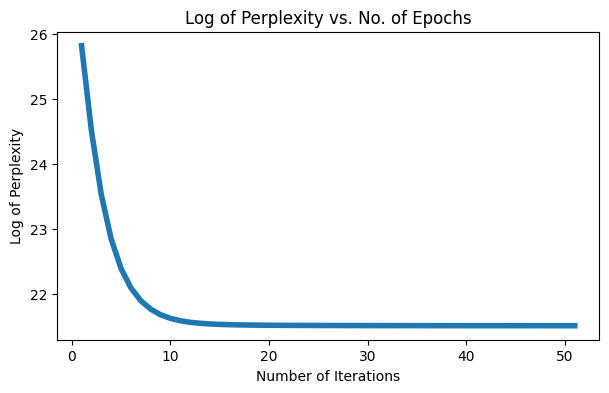

In [ ]:
plot_perplexity(toy_perp)

We can clearly see that the Perplexity is decreasing with each iteration through the parallel corpus.

**Alignments Check**

Now we have a look at the alignments learner by the model. We will also look at some visualization of alignments.

In [ ]:
# Check the alignments learned
pd.DataFrame(toy_align).round(5)

,flower,the,blue,apple,house
la,0.00000,1.00000,0.00000,0.00000,0.00000
fleur,0.98908,0.01092,0.00000,0.00000,0.00000
maison,0.00000,0.01092,0.00000,0.00000,0.98908
bleu,0.00000,0.00000,1.00000,0.00000,0.00000
pomme,0.00000,0.00000,0.01044,0.98956,0.00000


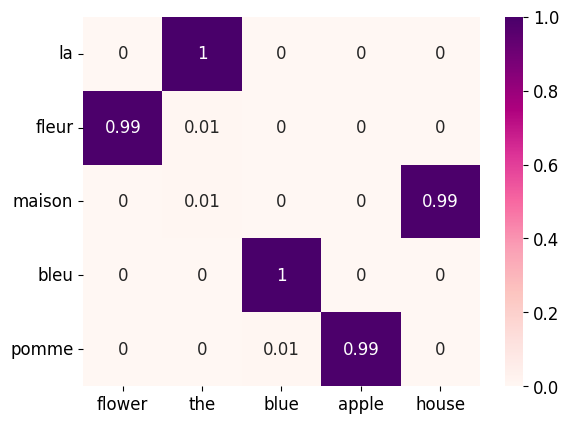

In [ ]:
# Visualize the alignments  (cmap default --> 'RdPu')
# cmap options --> 'RdPu', 'gray_r', 'cubehelix'
plot_alignments(toy_align)

From the above visuals we can clearly make out that the model has learned the alignments correctly as follows.

```
la        -->    the
pomme     -->    apple
maison    -->    house
bleu      -->    blue
fleur     -->    flower
```

In [ ]:
translate_sent(toy_corpus[0]['fr'], toy_corpus[0]['en'] , toy_align)

Input_(French):= la maison
Predicted_(English):= the house
True English Sentence: the house
#Matches:= 2	 Pred_Length:= 2 	 True_Length:= 2
---------------------------------------------------------------------------------------------


('the house', 2, 2, 2)

Till now we had seen the working of the model on a toy dataset. Now we will be going throught the same steps with our actual data.

1. Import & see the Data.
2. Cleaning of Data.
3. Verification of `Zipf's Law`.
4. Take a sample of our final cleaned data.
5. Train IBM Model 1 on this sample.
6. Test on some test sentences.

# Working with Actual Data

## Import Data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to DATA on GDrive
path_data = '/content/drive/MyDrive/SMT_Project/fra-eng/fra.txt'

In [ ]:
# Read the text data
with open(path_data, 'r') as filehandler:
  data = filehandler.read()

In [ ]:
# Check the Type & length of data
print(type(data)), print(len(data))

<class 'str'>
27038271


(None, None)

In [ ]:
# Check some rows of the data
data[:500]

'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)\nHi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)\nHi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)\nRun!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)\nRun!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)\nWho?\tQui ?\tCC-BY 2.0 (France) Attr'

In [ ]:
# Read the data as a pandas DataFrame
df = pd.read_csv(path_data, sep='\t')
df.head()

,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
0,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Who?,Qui ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [ ]:
# Check for Column Lables & number of Columns
df.columns.values, len(df.columns.values)

(array(['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       dtype=object),
 3)

1. There are 3 columns but the 3rd column is not useful, hence we will delete this column.
2. Here the data has taken the 1st sentence pair as column lables. So, we have to read data again without headers.

## Data Pre-processing and Cleaning

In [ ]:
# Read data again without header
df = pd.read_csv(path_data, sep="\t", header=None)
df.head()

,0,1,2
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
# Drop 3rd Column from parallel corpora
df.drop(df.columns[[2]], axis=1, inplace=True)

# Assign labels to columns
df.columns = ['en', 'fr']

In [ ]:
df.head()

,en,fr
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [ ]:
# Checking some random sentences
df[30:40]

,en,fr
30,Cheers!,Merci !
31,Cheers!,Tchin-tchin !
32,Get up.,Lève-toi.
33,Get up.,Lève-toi !
34,Go now.,"Va, maintenant."
35,Go now.,Allez-y maintenant.
36,Go now.,Vas-y maintenant.
37,Got it!,J'ai pigé !
38,Got it!,Compris !
39,Got it?,Pigé ?


Here, we can observe that the sentence number 32 & 33 has `Lève-toi.` & `Lève-toi !` which are same except for the punctuations that creates two duplicate sentences. Hence, we are going to remove all the punctuations from all the sentences and then delete the duplicate sentence pair with respect to the French sentences and not English sentences as different French sentences can have the same English translation.

In [ ]:
# Check random example
df[179898:179900]

,en,fr
179898,We need to uphold laws against discrimination ...,Nous devons faire respecter les lois contre la...
179899,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."


Here, we can see open & close quotations `"`, `«`, `»`. These needs to be removed.

In [ ]:
# Cleaning of dataframe

def CleanDataFrame(dataframe):

  '''
      Input: A pandas DataFrame
  '''

  # Remove ,?.{}()\";!@%$# these symbols as it remails the same.
  dataframe = dataframe.replace(r'[«,»?.{}()\";!@%$#]', '', regex=True)
  # dataframe = dataframe.replace(r'[][]+', '', regex=True)

  # Remove [] brackets
  dataframe = dataframe.replace('[','').replace(']','')

  # Convert to lower case & remove extra spaces
  dataframe = dataframe.apply(lambda x: x.astype(str).str.lower().str.strip())

  # Remove leading and trailing spaces
  dataframe = dataframe.replace(r"^ +| +$", r"", regex=True)

  # Delete duplicates
  dataframe.drop_duplicates(subset=['fr'], inplace=True)

  return dataframe

In [ ]:
df = CleanDataFrame(df)
df

,en,fr
0,go,va
1,hi,salut
3,run,cours
4,run,courez
5,who,qui
...,...,...
179899,top-down economics never works said obama the ...,l'économie en partant du haut vers le bas ça n...
179900,a carbon footprint is the amount of carbon dio...,une empreinte carbone est la somme de pollutio...
179901,death is something that we're often discourage...,la mort est une chose qu'on nous décourage sou...
179902,since there are usually multiple websites on a...,puisqu'il y a de multiples sites web sur chaqu...


In [ ]:
# Check for cleaned data
df[30:40]

,en,fr
32,get up,lève-toi
34,go now,va maintenant
35,go now,allez-y maintenant
36,go now,vas-y maintenant
37,got it,j'ai pigé
38,got it,compris
39,got it,pigé
41,got it,t'as capté
42,hop in,monte
43,hop in,montez


In [ ]:
# Check after Cleaned data
df.head()

,en,fr
0,go,va
1,hi,salut
3,run,cours
4,run,courez
5,who,qui


## Verification of Zipf's Law

The product of `rank r` of each word (sorted by frequency) and its `frequency f` is roughly a constant.

$~~~~~~~~~~~~~~~~ r * f = c  $

i.e $~~~~~~~~~~~~\log f = \log c - \log r $


In [ ]:
# Frequency of words
def word_freq(data_series,lang):

  # Create tokens from all sentences
  tokens = list()
  for i, sent in enumerate(data_series[lang]):
    tokens.extend(sent.split())

  # Create a dictionary of Word Frequency
  word_freq = Counter(tokens)

  print(f'Total Unique words := {len(word_freq)}')
  print(f'Total words in {lang}:= {sum(word_freq.values())}')

  return word_freq

In [ ]:
# Frequency of English words
en_word_freq = word_freq(df,'en')

Total Unique words := 15163
Total words in en:= 1046715


In [ ]:
# Frequency of French words
fr_word_freq = word_freq(df,'fr')

Total Unique words := 30107
Total words in fr:= 1111573


In [ ]:
# Plot of word frequencies
def plot_word_freq(word_freq_dict,lang, top=20):
  plt.figure(figsize=(15,5))
  plt.title(f"Most Frequent Words in the {lang} Corpus", fontsize = 20)
  labels = [pair[0] for pair in word_freq_dict.most_common(top)]
  counts = [pair[1] for pair in word_freq_dict.most_common(top)]
  plt.ylabel("Count")
  plt.xlabel("Word")
  plt.xticks(range(top),labels, rotation = 'vertical')
  plot = sns.barplot(counts, color='orange')
  return plot

<Axes: title={'center': 'Most Frequent Words in the English Corpus'}, xlabel='Word', ylabel='Count'>

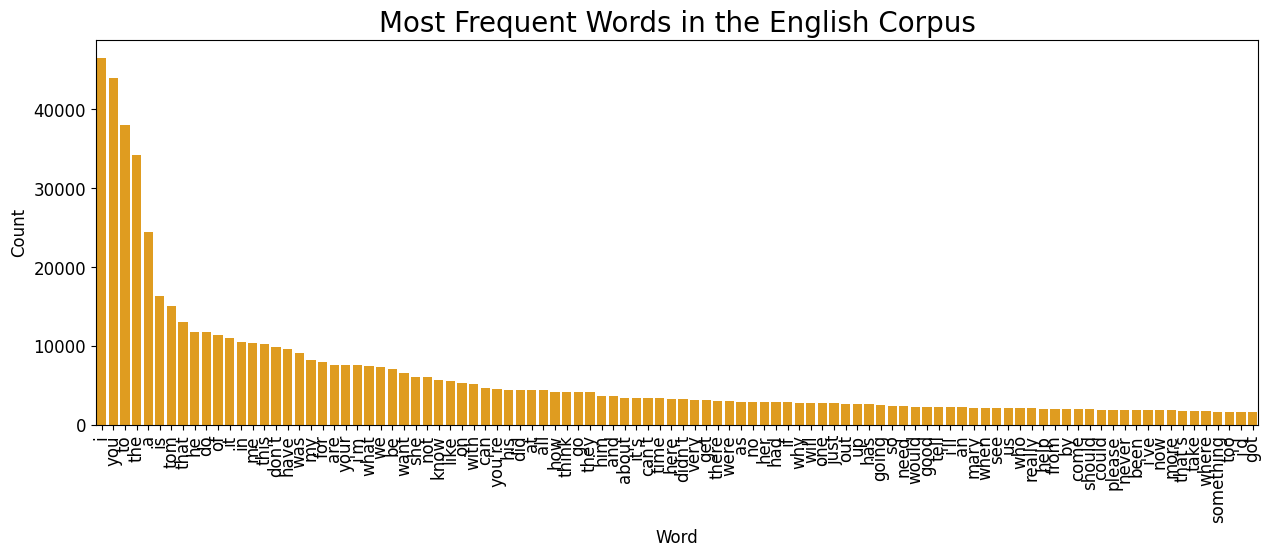

In [ ]:
# Visualization for verification of Zipf's Law
plot_word_freq(en_word_freq, 'English', 100)

<Axes: title={'center': 'Most Frequent Words in the French Corpus'}, xlabel='Word', ylabel='Count'>

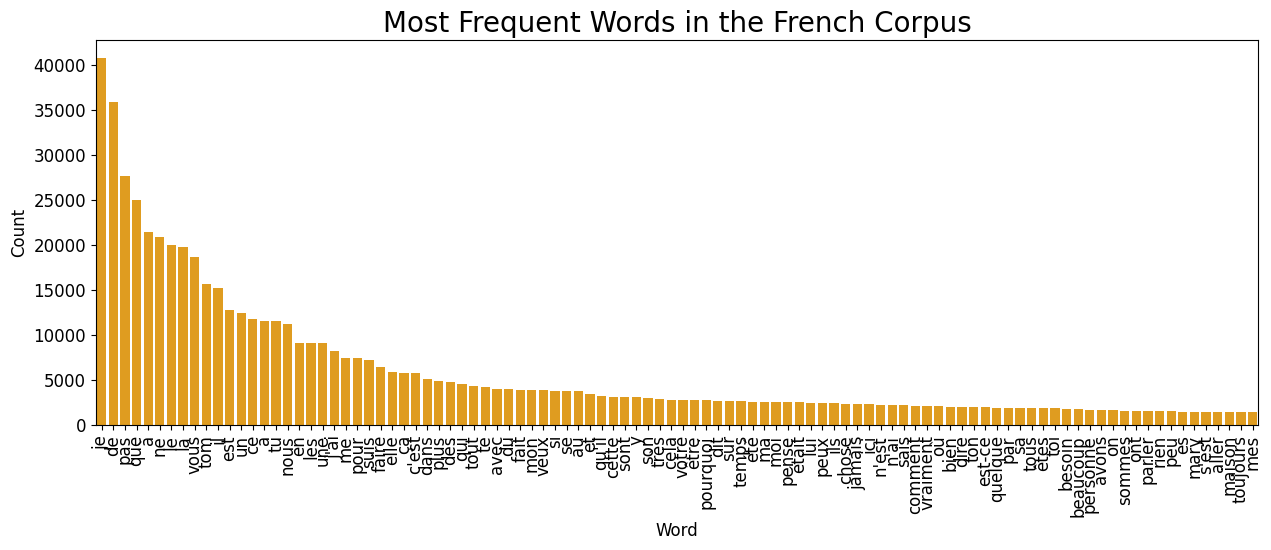

In [ ]:
# Visualization for verification of Zipf's Law
plot_word_freq(fr_word_freq, 'French', 100)

In [ ]:
def plot_word_freq_top(word_freq_dict, lang, top=30):
  data = Counter(word_freq_dict)

  # Labels, Counts and Rank*Count
  labels = [pair[0] for pair in data.most_common(top)]
  counts = [pair[1] for pair in data.most_common(top)]
  log_counts = [math.log(x) for x in counts]
  log_range = [math.log(num) for num in range(1, top+1)]

  # Figure Size
  plt.figure(figsize=(15, 5))

  # Plot 1
  plt.subplot(121)
  plt.scatter(labels, counts, color='chartreuse')
  plt.xticks(rotation = 'vertical')
  plt.xlabel('Rank of Words')
  plt.ylabel('Word Frequency')
  plt.title('Plot of Word Frequency', fontsize=10)

  # Plot 2
  plt.subplot(122)
  plt.scatter(log_range, log_counts)
  plt.xlabel('Log of Rank of Words')
  plt.ylabel("Log of Word Frequency")
  plt.title('Plot of log(Rank) vs log(Frequency)', fontsize=10)

  # Title
  plt.suptitle(f"Verification of Zipf's Law - {lang} corpus", fontsize=20)
  # plt.show()

  return plt.show()

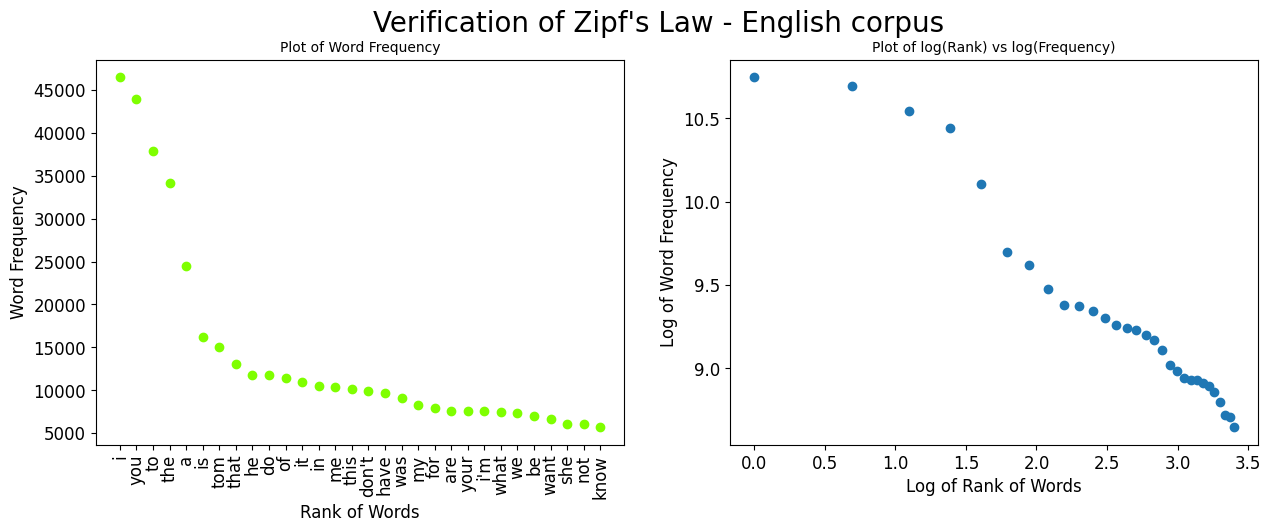

In [ ]:
# Zipf's Law for English corpus
plot_word_freq_top(en_word_freq,'English')

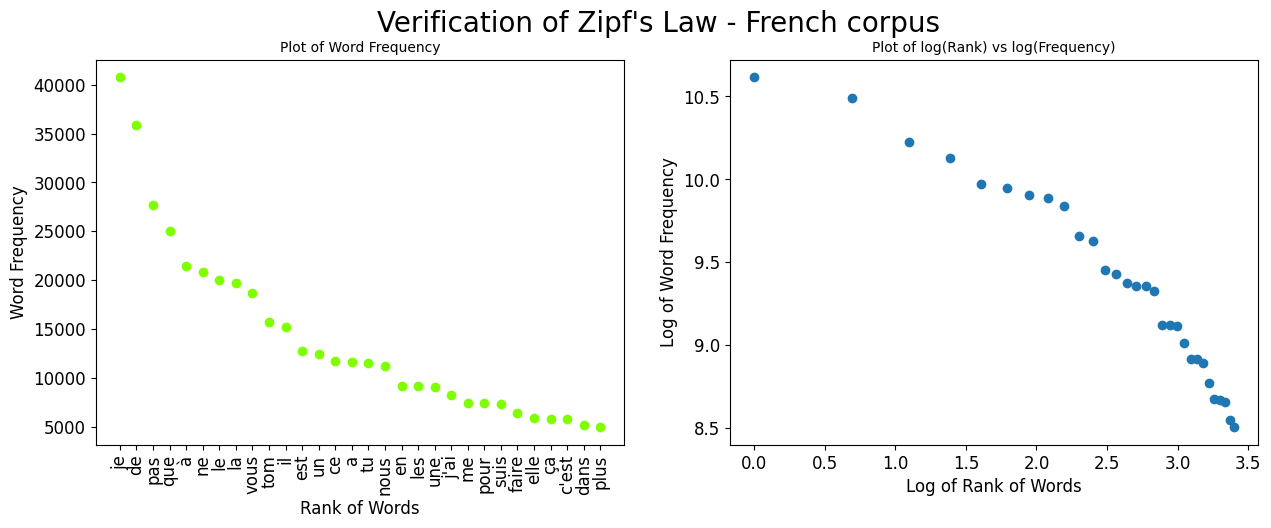

In [ ]:
# Zipf's Law for French corpus
plot_word_freq_top(fr_word_freq,'French')

We observe from the second plot for both the English & French corpus that the scatter does show a slight linear behaviour between `log(rank) & log(frequency)`.

One of the reason for the lack of strong linear behaviour might be due to the fact that a very small part of data was used for visualization in comparison to the entire data. Due to which we are not able to have a much clear picture of `Zipf's Law`.

**Conclusion:** `Zipf's Law` is verified.

## Analysis of length of sentences

In [ ]:
df['en_words'] = df['en'].str.split(' ').str.len()
df['fr_words'] = df['fr'].str.split(' ').str.len()

In [ ]:
df.head()

,en,fr,en_words,fr_words
0,go,va,1,1
1,hi,salut,1,1
3,run,cours,1,1
4,run,courez,1,1
5,who,qui,1,1


In [ ]:
# Summary of word counts
round(df.describe())

,en_words,fr_words
count,168951.0,168951.0
mean,6.0,7.0
std,3.0,3.0
min,1.0,1.0
25%,4.0,5.0
50%,6.0,6.0
75%,7.0,8.0
max,44.0,55.0


We can observe that 75% on the data has sentences of length upto 7 for English corpus whereas the length is upto 8 for French corpus.

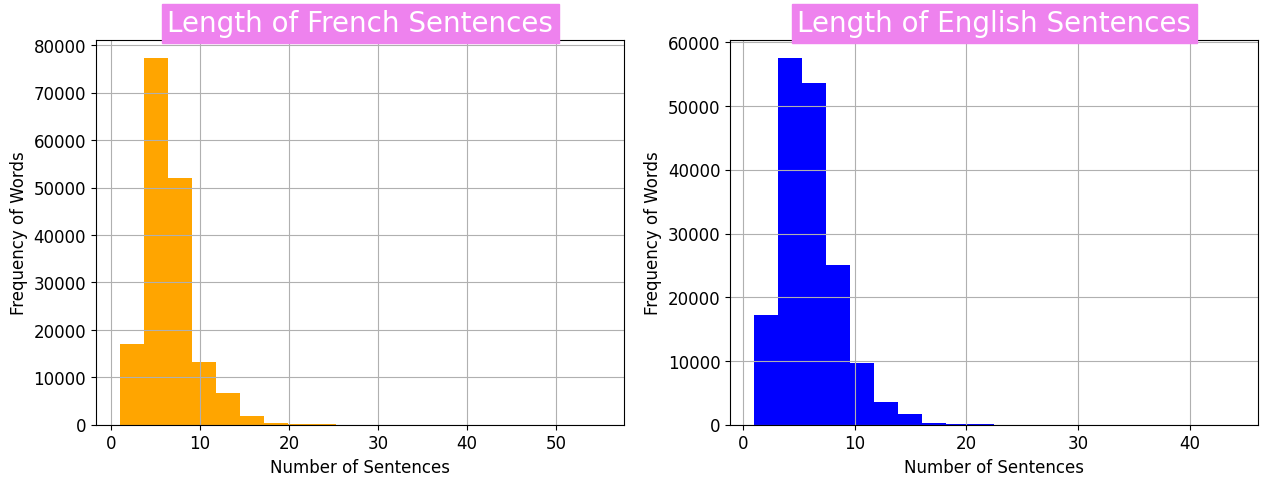

In [ ]:
# Visualize length of French & English sentences.

fr = df["fr_words"]
en = df["en_words"]

plt.subplots(figsize=(15,5))

plt.subplot(121)
fr.hist(bins=20, color='orange')
plt.title("Length of French Sentences",fontsize = 20, fontweight = 5, color= 'white',backgroundcolor='violet')
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency of Words")

plt.subplot(122)
en.hist(bins=20, color='b')
plt.title("Length of English Sentences",fontsize = 20, fontweight = 5, color= 'white',backgroundcolor='violet')
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency of Words")

plt.show()

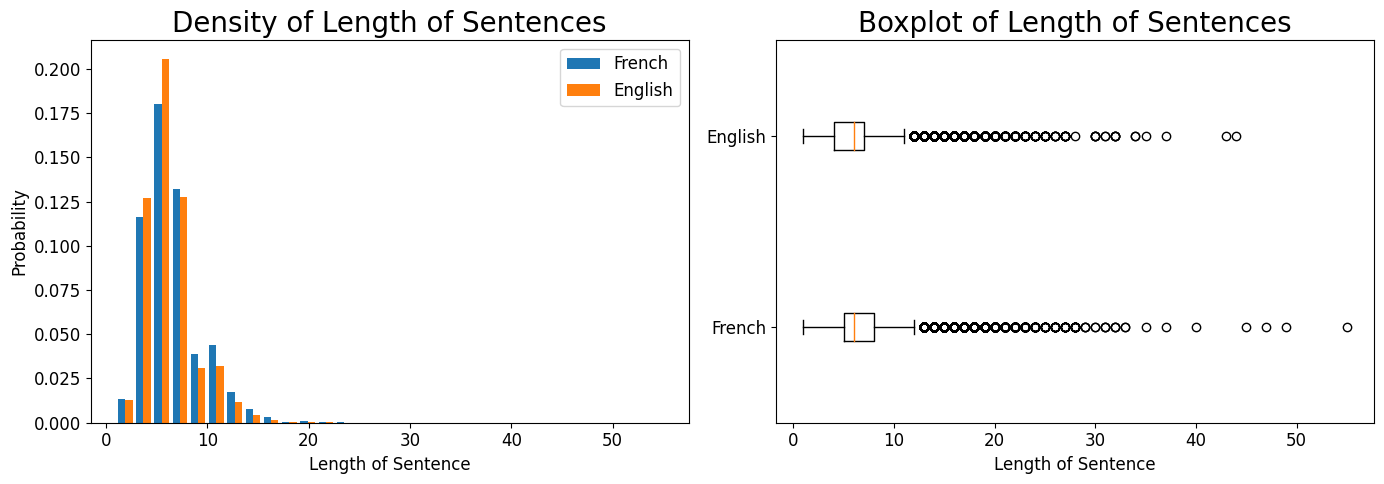

In [ ]:
# Density & BoxPlot for better visualization
plt.subplots(figsize=(14,5))

plt.subplot(1,2,1)   # Postion of 1st plot (row,column,index)
plt.hist([fr,en],bins=30,density=True)
plt.legend(labels=("French","English"))
plt.xlabel("Length of Sentence")
plt.ylabel("Probability")
plt.title("Density of Length of Sentences",fontsize = 20, fontweight = 5)

plt.subplot(1,2,2)
plt.boxplot([fr,en],vert=False,labels=("French","English"))
plt.title("Boxplot of Length of Sentences",fontsize = 20, fontweight = 5)
plt.xlabel("Length of Sentence")
plt.tight_layout()
plt.show();

From the graph we can see that all sentences have length more than 0 and there are not too many sentences with length more than 10. So, we will restrict ourselves to sentences having length upto 10 as we have less computational power.

In [ ]:
# Sentences with 10 or more words
print('French Sentences with 10 or more words :',sum(df['fr_words']>10))
print('English Sentences with 10 or more words :',sum(df['en_words']>10))

French Sentences with 10 or more words : 14608
English Sentences with 10 or more words : 9681


In [ ]:
# We will be left with
print('French Sentences with 10 or more words :',sum(df['fr_words']<10))
print('English Sentences with 10 or more words :',sum(df['en_words']<10))

French Sentences with 10 or more words : 146305
English Sentences with 10 or more words : 153332


In [ ]:
# Delete sentences with length more than 10
df_sent10 = df[(df.fr_words < 10) & (df.en_words < 10)]
print(f"Number of Sentences := {len(df_sent10)}")

Number of Sentences := 142958


## Check our final cleaned corpus

In [ ]:
print("Number of Sentences in cleaned corpus :=",len(df_sent10))

Number of Sentences in cleaned corpus := 142958


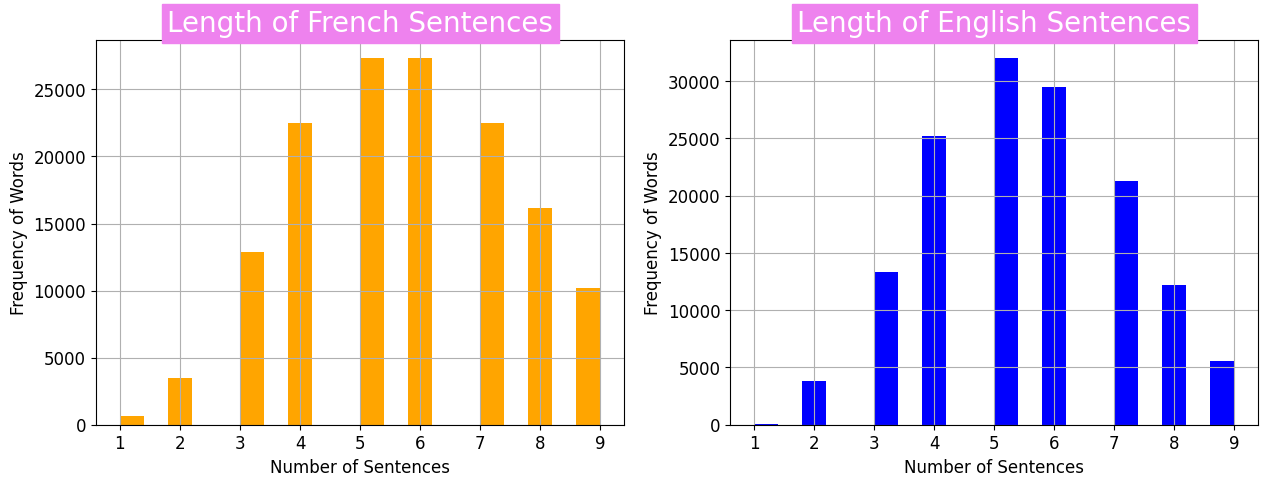

In [ ]:
# Check graph of length of sentences after deleting sentences > 10
fr = df_sent10["fr_words"]
en = df_sent10["en_words"]

plt.subplots(figsize=(15,5))

plt.subplot(121)
fr.hist(bins=20, color='orange')
plt.title("Length of French Sentences",fontsize = 20, fontweight = 5, color= 'white',backgroundcolor='violet')
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency of Words")

plt.subplot(122)
en.hist(bins=20, color='b')
plt.title("Length of English Sentences",fontsize = 20, fontweight = 5, color= 'white',backgroundcolor='violet')
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency of Words")

plt.show()

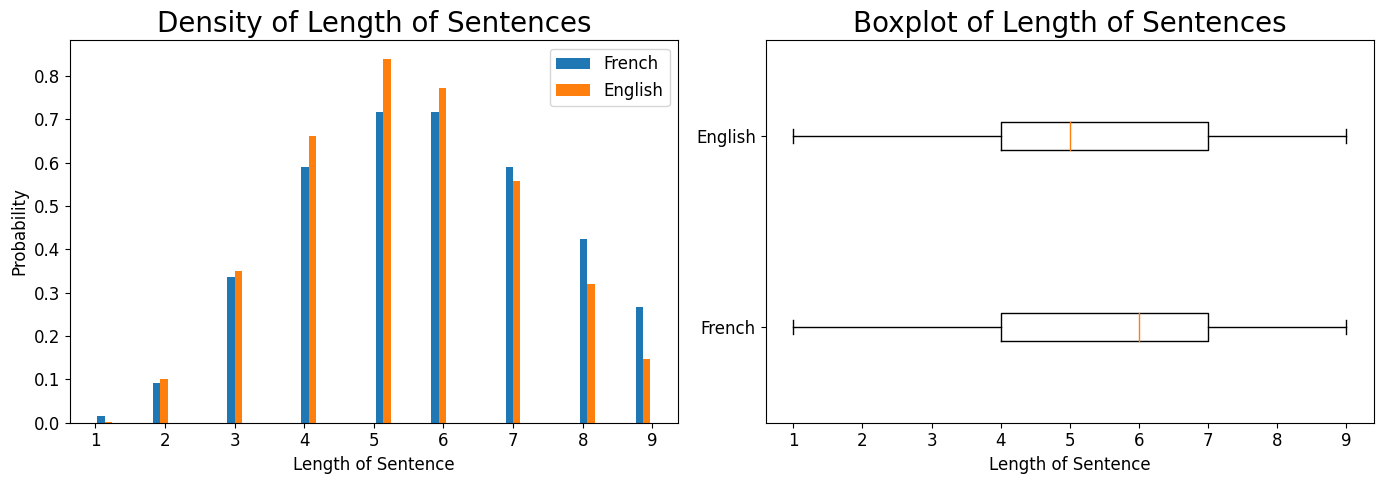

In [ ]:
# Graph of sentence length after deleting sentences > length 10
plt.subplots(figsize=(14,5))

plt.subplot(1,2,1)   # Postion of 1st plot (row,column,index)
plt.hist([fr,en],bins=30,density=True)
plt.legend(labels=("French","English"))
plt.xlabel("Length of Sentence")
plt.ylabel("Probability")
plt.title("Density of Length of Sentences",fontsize = 20, fontweight = 5)

plt.subplot(1,2,2)
plt.boxplot([fr,en],vert=False,labels=("French","English"))
plt.title("Boxplot of Length of Sentences",fontsize = 20, fontweight = 5)
plt.xlabel("Length of Sentence")
plt.tight_layout()
plt.show()

Now the data looks good to proceed with Model training.

In [ ]:
# Delete columns en_words & fr_words
df_sent10.drop(columns=['en_words', 'fr_words'], axis=1, inplace = True)
df_sent10.head()

,en,fr
0,go,va
1,hi,salut
3,run,cours
4,run,courez
5,who,qui


This is the Final Dataframe from English to French. So, we convert it to French to English.

In [ ]:
# Interchange Columns of Dataframe - For ease of Translation
new_columns = ['fr', 'en']
df_new = df_sent10[new_columns]
df_new.head()

,fr,en
0,va,go
1,salut,hi
3,cours,run
4,courez,run
5,qui,who


Now our Final corpus is ready to be Modelled.

# Train-Test Split

`Train Size = 80%`

`Test Size = 20%`

In [ ]:
# Split data into training and testing
def train_test_split(df, train_size):

  final_df = df.copy()

  train_data = final_df.sample(frac= train_size, random_state=1424)
  test_data = final_df.drop(train_data.index)

  # Display
  print("Size of Training Data :", len(train_data))
  print("Size of Testing Data :", len(test_data))

  return train_data, test_data

In [ ]:
# Train Test Split
train_tot, test_tot = train_test_split(df_new, 0.8)

Size of Training Data : 114366
Size of Testing Data : 28592


# Training on a 500 Sample Train Dataset

In [ ]:
# We take a sample of 500 sentences for Training
train_500 = list(train_tot[:500].to_dict('records'))
test_10 = list(train_tot[:10].to_dict('records'))

In [ ]:
# Training on Sample of 500
train_500_align, train_500_perp, train_500_iter  = train(train_500, 50)

Alignments Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 0 := Log of Perplexity --> 10869.087699430278
Epoch 10 := Log of Perplexity --> 9181.587378940823
Epoch 20 := Log of Perplexity --> 9164.587890441968
Epoch 30 := Log of Perplexity --> 9162.483404864024
Epoch 40 := Log of Perplexity --> 9161.902170757634
Epoch 50 := Log of Perplexity --> 9161.671942616264


Save the Trained Model first, load it and then use it for further computation, as if the code craches then the model can be loaded and used instead of running all cells again.

In [ ]:
path = '/content/drive/MyDrive/SMT_Project'
align_filename = "train_500_align"
perp_filename = "train_500_perp"

In [ ]:
# First save the Model Alignments learned
# '/content/drive/MyDrive/SMT_Project
# align_filename = train_500_align.h5'
# '/content/drive/MyDrive/SMT_Project
# perp_filename = train_500_align.h5'

def save_align_perp(align, align_filename, perp, perp_filename, path):
  joblib.dump(align, '/'.join([path, align_filename]))
  joblib.dump(perp, '/'.join([path, perp_filename]))

  return print(f"Files Saved := {path}")

In [ ]:
save_align_perp(train_500_align, align_filename, train_500_perp, perp_filename, path)

Files Saved := /content/drive/MyDrive/SMT_Project


In [ ]:
# Load alignment & perplexity
# path = '/content/drive/MyDrive/SMT_Project/
# align_filename = train_500_align.h5'
# perp_filename = 'train_500_perp.h5'

def load_align_perp(align_filename, perp_filename, path):
  align = joblib.load('/'.join([path, align_filename]))
  perp = joblib.load('/'.join([path, perp_filename]))

  return align, perp

In [ ]:
path = '/content/drive/MyDrive/SMT_Project'
align_filename = 'train_500_align'
perp_filename = 'train_500_perp'

In [ ]:
# Load the model from the file
align_500, perp_500 = load_align_perp(align_filename, perp_filename, path)

[]

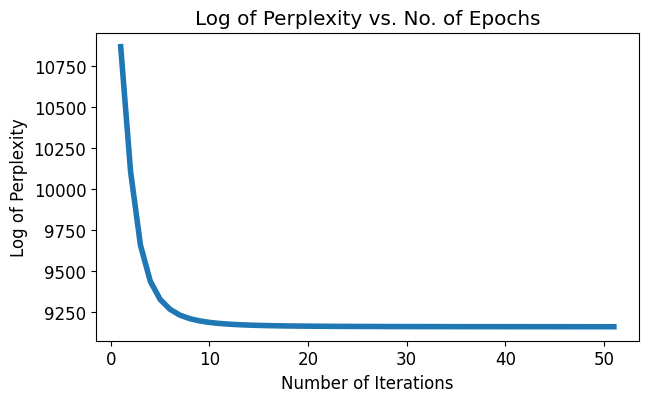

In [ ]:
plot_perplexity(perp_500)

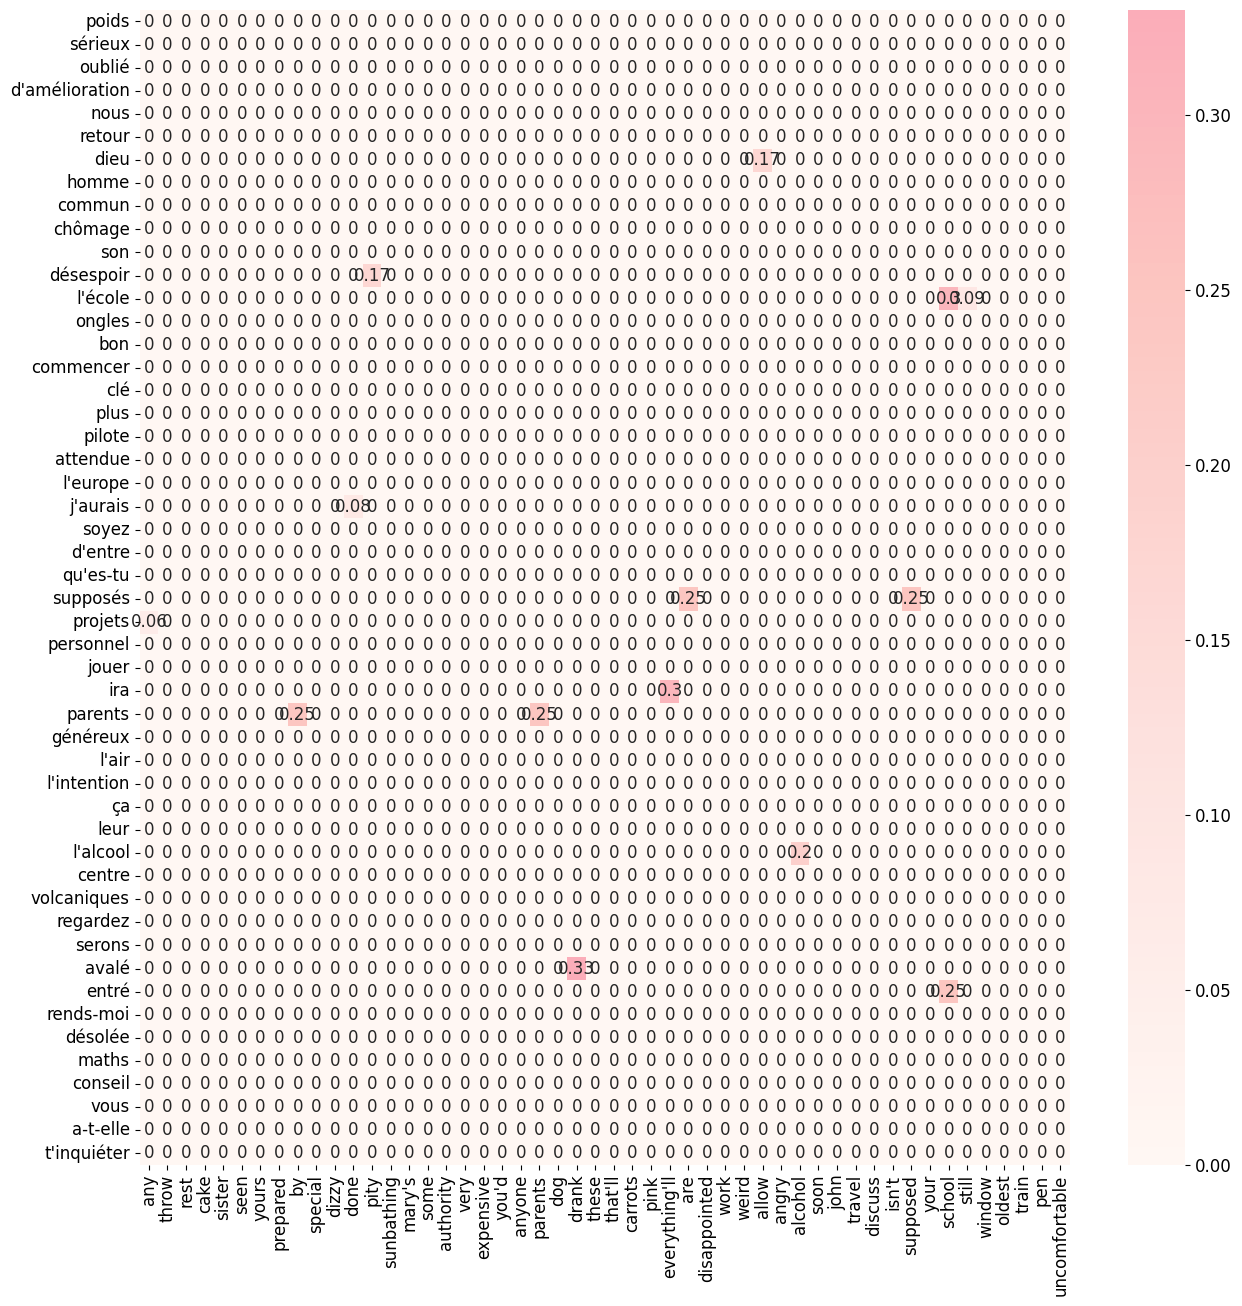

In [ ]:
# Plot 1
sample_align_20 = pd.DataFrame(align_500).iloc[:50,:50]
plot_alignments(sample_align_20)

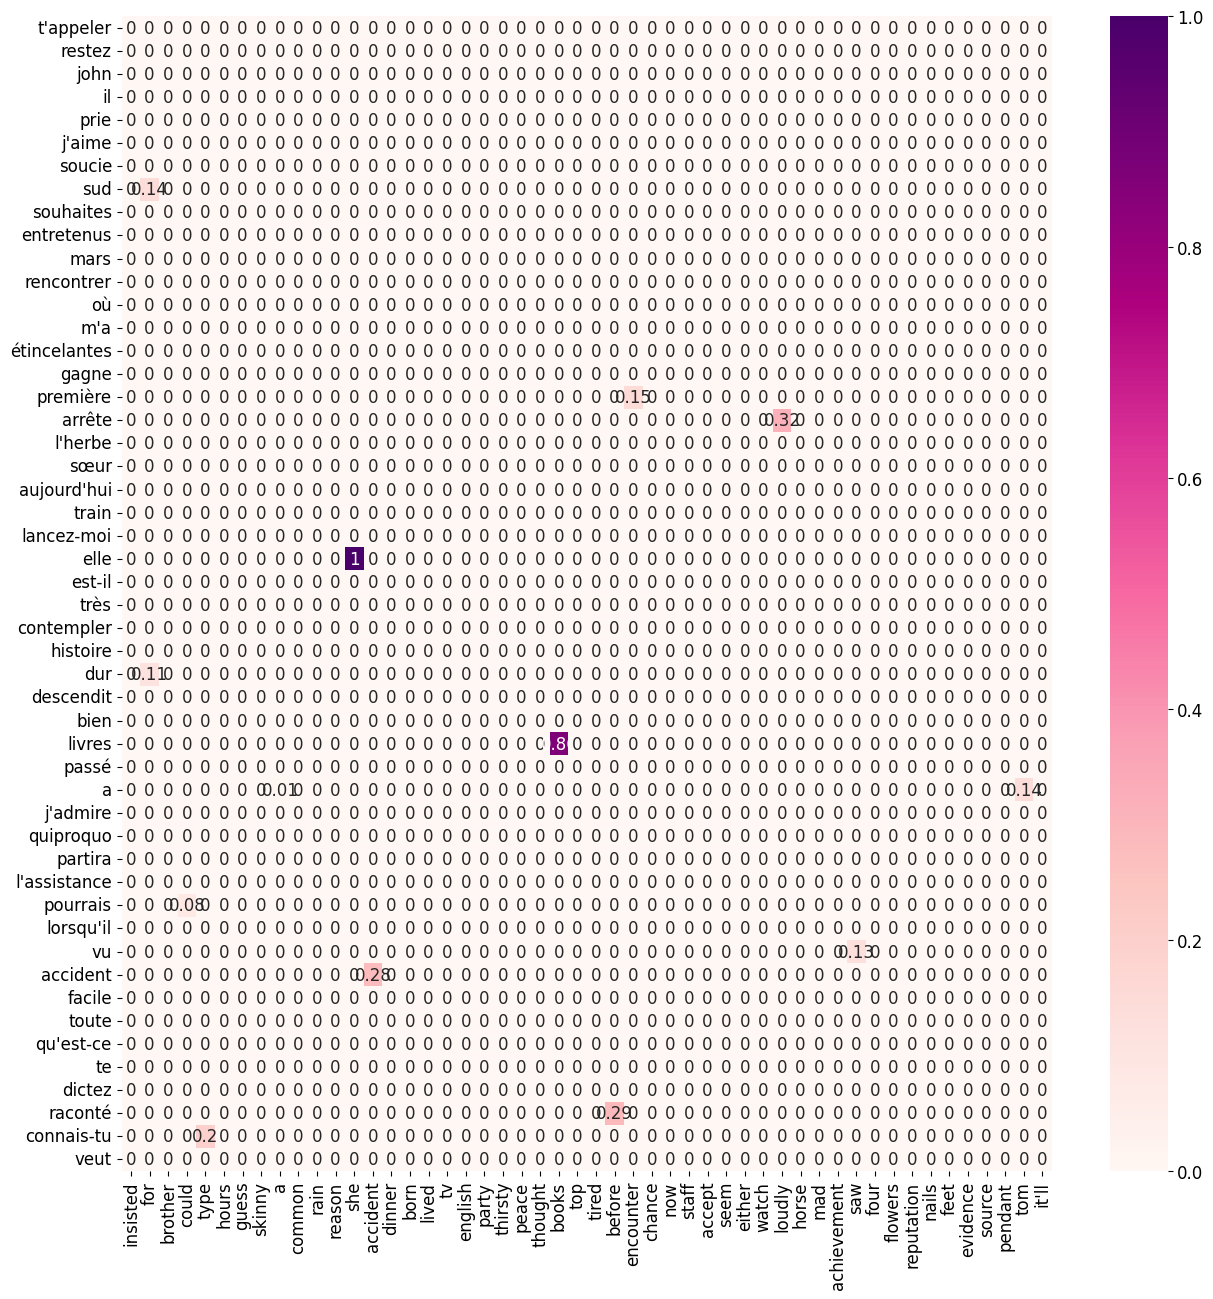

In [ ]:
# Plot 2
sample_align_20 = pd.DataFrame(align_500).iloc[50:100,50:100]
plot_alignments(sample_align_20)

## Testing on Test Data

In [ ]:
# Test sentences
test_10

[{'fr': 'tom fait toujours cela', 'en': 'tom always does that'},
 {'fr': "qu'est-ce qu'il devient", 'en': 'what has become of him'},
 {'fr': 'vas-tu à l’école', 'en': 'are you going to school'},
 {'fr': 'je suis habitué à être ignorée de mes parents',
  'en': "i'm used to being ignored by my parents"},
 {'fr': "c'est une distance incroyable n'est-ce pas",
  'en': "that's an amazing distance isn't it"},
 {'fr': "pourriez-vous baisser le gaz s'il vous plaît",
  'en': 'could you turn the heat down please'},
 {'fr': 'ça ressemble à un mariage', 'en': 'it looks like a wedding'},
 {'fr': "j'ai vu un oiseau magnifique", 'en': 'i saw a beautiful bird'},
 {'fr': 'quelle sorte de voiture conduisez-vous',
  'en': 'what kind of car do you drive'},
 {'fr': "j'aurais aimé que vous puissiez être venues avec moi",
  'en': 'i wish you could have come with me'}]

In [ ]:
trans_sent = []
no_match = []
len_trans_sent = []
len_true_sent = []


for i, sent in enumerate(test_10):
  print(f"==============   SENTENCE {i+1}   ==============")
  temp_trans_sent, temp_no_match, temp_len_trans_sent, temp_len_true_trans = translate_sent(sent['fr'], sent['en'], align_500)
  trans_sent.append(temp_trans_sent)
  no_match.append(temp_no_match)
  len_trans_sent.append(temp_len_trans_sent)
  len_true_sent.append(temp_len_true_trans)

==============   SENTENCE 1   ==============
Input_(French):= tom fait toujours cela
Predicted_(English):= tom done always that
True English Sentence: tom always does that
#Matches:= 3	 Pred_Length:= 4 	 True_Length:= 4
---------------------------------------------------------------------------------------------
==============   SENTENCE 2   ==============
Input_(French):= qu'est-ce qu'il devient
Predicted_(English):= what need him
True English Sentence: what has become of him
#Matches:= 2	 Pred_Length:= 3 	 True_Length:= 5
---------------------------------------------------------------------------------------------
==============   SENTENCE 3   ==============
Input_(French):= vas-tu à l’école
Predicted_(English):= school to school
True English Sentence: are you going to school
#Matches:= 3	 Pred_Length:= 3 	 True_Length:= 5
---------------------------------------------------------------------------------------------
==============   SENTENCE 4   ==============
Input_(French):= je suis

# Language Model

**Tri-Gram Model**

In [ ]:
import nltk
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Tri Gram Frequency
for sent in train_500:
  data = sent['en'].split()
  for w1, w2, w3 in trigrams(data, pad_right=True, pad_left=True):
      model[(w1, w2)][w3] += 1


# Find probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [ ]:
sorted(dict(model["it","looks"]).items(), key=lambda x:-1*x[1])

[('like', 1.0)]

In [ ]:
sorted(dict(model["wish","you"]).items(), key=lambda x:-1*x[1])

[('could', 1.0)]

In [ ]:
sorted(dict(model["are","you"]).items(), key=lambda x:-1*x[1])

[('going', 0.07692307692307693),
 ('in', 0.07692307692307693),
 ('pretending', 0.07692307692307693),
 ('here', 0.07692307692307693),
 ('having', 0.07692307692307693),
 ('dressed', 0.07692307692307693),
 ('real', 0.07692307692307693),
 ('good', 0.07692307692307693),
 (None, 0.07692307692307693),
 ('studying', 0.07692307692307693),
 ('envious', 0.07692307692307693),
 ('questioning', 0.07692307692307693),
 ('so', 0.07692307692307693)]

**Generate Sentence using Tri-Gram Model**

In [ ]:
import random

# starting words
text = ["wish", "you"]
sentence_finished = False

while not sentence_finished:
  # select a random probability threshold
  prob = random.random()
  accumulator = .0

  for word in model[tuple(text[-2:])].keys():
      accumulator += model[tuple(text[-2:])][word]

      # Select word with higher probability
      if accumulator >= prob:
          text.append(word)
          break

  if text[-2:] == [None, None]:
      sentence_finished = True

print (' '.join([t for t in text if t]))

wish you could have come with me


Saving as PDF

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!jupyter nbconvert --to pdf "SMT_IBM_Model1_French_English.ipynb"

In [ ]:
!jupyter nbconvert --to html "SMT_IBM_Model1_French_English.ipynb"

In [ ]:
# %%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('SMT_IBM_Model1_French_English.ipynb')

In [ ]:
# @title Default title text
